## Battery Charging Model 
Inspired by "[2] Optimizing the operation of energy storage using a non-linear lithium-ion battery degradation model"

### Objective Functions 
1. Balances Cost and Degradation (Multi-Objetive Optimization) \
$\zeta = \omega{C} + (1 - \omega)D$ \
$\boldsymbol{\omega}$ $\rightarrow$ weighting factor $[0 \rightarrow 1]$ \
$\boldsymbol{D} \rightarrow$ total degradation in market period $[Ah]$\
$\boldsymbol{C} \rightarrow cost $ [\$]\
2. Aims to minimize cost \
$C = \sum_t[\lambda_t \times (P_t^{dis,m} - P_t^{ch,m})]\times\Delta{T}$ \
$\boldsymbol{C} \rightarrow $ market clearing price $[\frac{\$}{Wh}]$\
$\boldsymbol{\lambda_t} \rightarrow revenue [dollars]$ \
$\boldsymbol{P_t^{dis,m}} \rightarrow$ max power input to battery in trading interval $[W]$ \
$\boldsymbol{P_t^{ch, m}} \rightarrow$ max power output to battery in trading interval $[W]$ \
$\boldsymbol{\Delta{T}} \rightarrow$ duration of trading interval $[hr]$ \
3. Aims to reduce degradation
$D = \sum_t{d_t}$\
$\boldsymbol{D} \rightarrow$ total degradation in market period $[Ah]$\
$\boldsymbol{d_t} \rightarrow$ total degradation incurred in each period $[Ah]$\



### Battery Updates
4. Updates the state of the battery\
${SOC} = {SOC}_{t-1} + \frac{(P_t^{dis,m} - P_t^{ch,m})\times\Delta{T}}{V_{nom}I_{1C}}$\
$\boldsymbol{SOC_t} \rightarrow$ state of charge, % measure of remaining capacity $[0 \rightarrow 100]$\
$\boldsymbol{P_t^{dis,m}} \rightarrow$ max power output to battery in trading interval $[W]$ \
$\boldsymbol{P_t^{ch, m}} \rightarrow$ max power input to battery in trading interval $[W]$ \
$\boldsymbol{\Delta{T}} \rightarrow$ duration of trading interval $[hr]$ \
$\boldsymbol{V_{nom}} \rightarrow$ nominal battery voltage $[V]$: The reported or reference voltage of the battery, $[4]$\
$\boldsymbol{I_{1C}} \rightarrow$ 1C Current $[A]$:s. A C-rate is a measure of the rate at which a battery is discharged relative to its
maximum capacity. A 1C rate means that the discharge current will discharge the entire
battery in 1 hour $[4]$

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial as P
import numdifftools as nd
import torch
import time
import pandas as pd
import datetime as dt
from scipy import optimize as optimize2


# Battery Class Definition Template
class Battery():
    # Defining global static class variables
    global SOC_x, cum_deg_y, i_x, psi_y
    
    # Cumulative degredation mapping manually determined based on fig 4 in the paper
    SOC_x = np.linspace(0.0, 100.0, num=11)
    cum_deg_y = np.array([0.0, 39.0, 47.0, 75.0, 75.0, 84.0, 101.0, 160.0, 269.0, 325.0, 372.0])
    
    # Psi scaling factor using experimental data to linearly interpolate depending on current
    i_x = np.array([0.0, 1.0, 2.0])
    psi_y = np.array([0.0, 1.0, 1.2956])
    
    
    # Initialize with instance variables for battery charging/degradation
    
    # SOC --> State of charge [represents measure of remaining capacity in percentage form]
    # V_nom --> Nominal Voltage [Volts]
    # P_ch_max --> Max power oup
    # charging --> boolen: True if charging, False if dissipating
    # eta --> Battery inefficiency constant (this is approximation from [2])
    def __init__(self):
        # Constants
        self.V_nom = 3.7            # [Volts] constant nominal operating voltage
        self.IC1 = 2.15             # [Amps] constant 1C rate current
        self.P_ch_max = 5           # [Watt] --> do research to determine starting value
        self.deltaT = 1             # [Hours] Duration of trading interval  
        
        # Variables
        self.SOC = None             # [Percentage] current battery percentage
        self.SOC_prev = None        # [Percentage] previous battery percentage
        self.d_t1C = None           # [Amp Hours] degredation at 1C charge during one time interval
        self.psi_t = None           # [unitless] scaling factor of degredation depending on current
        self.d_t = None             # [Amp Hours] total degredation at time interval t
        self.P_ch_b = None          # [Watt] current charge power input to battery
        self.SOC_penalties = []       # SOC constraint violation penalty
        
        
    def setSOC(self, val):
        # Updates the SOC
        self.SOC = val
        penalty_plus = np.square(np.maximum(val - 100, 0))
        penalty_minus = np.square(np.minimum(val, 0))
        self.SOC_penalties.append(penalty_plus + penalty_minus)
        
        #Ensure that SOC lies in between 0 and 100 (constraint 7)
        self.SOC = np.maximum(0, self.SOC)
        self.SOC = np.minimum(100, self.SOC)
              
                
    def updateSOC(self):
        # Updates the SOC from one trading interval to the next    
        self.SOC_prev = self.SOC
        new_SOC = self.SOC_prev + 100 * ((self.P_ch_b * self.deltaT) / (self.V_nom * self.IC1))
        self.setSOC(new_SOC)
    
    
    def getD_t1C(self):
        # Calculate d_t1C = abs(delta_t - delta_t-1)
        delta1C = np.interp(self.SOC, SOC_x, cum_deg_y)
        delta1C_prev = np.interp(self.SOC_prev, SOC_x, cum_deg_y)
        d_t1C = np.abs(delta1C - delta1C_prev)
        self.d_t1C = d_t1C
    

    def getPsi(self):
        # Calculate i_t and use to determine psi degradation scaling factor
        i_t = np.abs(self.P_ch_b) / (self.V_nom * self.IC1)
        psi_t = np.interp(i_t, i_x, psi_y)
        self.psi_t = psi_t
        
        
    def getD_t(self):
        # Calculate d_t as a function of d_t1C and psi_t
        d_t = ((self.d_t1C + self.psi_t) / 2) ** 2 - ((self.d_t1C - self.psi_t) / 2) ** 2
        self.d_t = d_t
        return d_t
    
    
    def calcIter(self, P_t):
        # Loops through iteration to calculate d_t given P_t
        self.P_ch_b = P_t
        self.updateSOC()
        self.getD_t1C()
        self.getPsi()
        d_t = self.getD_t()
        return d_t
    
    
    def calcTotal(self, P, SOC_0=50.0, verbose=False):
        # Given charging schedule P, calculate final degredation
        self.setSOC(SOC_0)
        self.SOC_penalties = []
        d_ts = []
        if verbose:
            SOC_ts, d_t1cs, psi_ts = [], [], []
        for t in range(len(P)):
            d_t = self.calcIter(P[t])
            d_ts.append(d_t)
            
            if verbose:
                SOC_ts.append(self.SOC_prev)
                d_t1cs.append(self.d_t1C)
                psi_ts.append(self.psi_t)
        
        
        d_ts = np.array(d_ts)
        D = np.sum(d_ts)
        if verbose:
            return D, SOC_ts, d_ts, d_t1cs, psi_ts
        return D
    

    def plotPsi(self):
        # Plots the psi schedule as a function of i = P / VI
        plt.figure(figsize=(8, 4))
        plt.plot(i_x, psi_y, marker='D')
        plt.xlabel("i ($h^{-1}$)")
        plt.ylabel("$\psi$")
        plt.title("Degradation Scaling Factor")
        
        
    def plotCum_Deg(self):
        # Plots essentially the same plot as fig 4 in the paper
        plt.figure(figsize=(8, 4))
        plt.plot(SOC_x, cum_deg_y, marker='D')
        plt.xlabel("SOC (%)")
        plt.ylabel("$\delta^{1C}$ ($\mu$Ah)")
        plt.title("Cumulative Degredation")
        

In [2]:
# Cost Class Definition Template
class Cost():
    # Initialize with instance variables for cost model

    # eta --> Battery inefficiency constant (this is approximation from [2])
    def __init__(self, t=2):
        # Constants
        self.eta = .95                   # [Constant] Initial guess at inefficiency constant
        self.deltaT = 1                  # [Hours] Duration of trading interval
        self.prices = 0.20 * np.ones(t)  # [Dollars / kWh] prices of electricity over discrete time intervals
        self.c_ts = []
    
    def calc(self, P):
        # calculates cost C given charging schedule P
        P = np.where(P > 0.0, P / self.eta, P)
        P = np.where(P < 0.0, P * self.eta, P)
        self.c_ts = (P * self.prices / 1000) * self.deltaT
        C = np.sum(self.c_ts)
        return C


In [3]:
def calcPenalty(P, battery, rho, rho_SOC):
    # calculate P_max constraint penalty using quadratic penalty method
    P_max = battery.P_ch_max
    penalty = rho * np.sum(np.square(np.maximum(np.abs(P) - P_max, 0)))
    
    # calculate SOC constraint penalty
    penalty += rho_SOC * np.sum(bat.SOC_penalties)
    return penalty


def objective(P, SOC_0=50.0, w_C=0.5, rho=1.0, rho_SOC=1.0, verbose=False):
    if verbose:
        C = cost.calc(P)
        D, SOC_ts, d_ts, d_t1cs, psi_ts = bat.calcTotal(P, SOC_0=SOC_0, verbose=True)
        cache = P, SOC_ts, d_ts, d_t1cs, psi_ts, bat.SOC_penalties, cost.prices, cost.c_ts, w_C
        penalty = calcPenalty(P, bat, rho=rho, rho_SOC=rho_SOC)
        objective = (w_C * C * 50000) + (1 - w_C) * D + penalty
        return objective, cache
    
    else:
        C = cost.calc(P)
        D = bat.calcTotal(P, SOC_0=SOC_0)
        penalty = calcPenalty(P, bat, rho=rho, rho_SOC=rho_SOC)
        objective = (w_C * C * 50000) + (1 - w_C) * D + penalty
        return objective


In [4]:
def normalize(g):
    length = np.linalg.norm(g)
    result = g / length
    return result


def gradient_descent(lr, n_iter, w_C, rho=1.0, rho_SOC=1.0, beta=0.4, lr_decay=1.0):
    P = np.random.uniform(low=-3.0, high=3.0, size=t)
#     P = np.ones(t) * 0
    v = np.zeros(t)
    losses, Ps, grads = [], [], []
    g = nd.Gradient(objective, full_output=True)
    for i in range(n_iter):
        grad, info = g(P, SOC_0=SOC_0, w_C=w_C, rho=rho, rho_SOC=rho_SOC)
        v = beta * v - (lr * normalize(grad))
        P += v
        lr *= lr_decay
        
        grads.append(grad.copy())
        losses.append(info)
        Ps.append(P.copy())
    losses = [i.f_value for i in losses]
    Ps = np.array(Ps)
    return P, grads, losses, Ps


def optimize(lr, n_iter, w_C, rho, rho_SOC, beta, lr_decay, trials=1):
    best_loss = np.inf
    best_P = None
    best_train_cache = None
    
    for i in range(trials):
        P, grads, losses, Ps = gradient_descent(lr, n_iter, w_C, rho, rho_SOC, beta, lr_decay)
        loss = objective(P)
        if loss < best_loss:
            best_loss = loss
            best_P = P
            best_train_cache = grads, losses, Ps
    return best_P, best_train_cache

In [5]:
def plotLoss(train_cache):
    grads, losses, Ps = train_cache
    fig, ax = plt.subplots(2, 2, figsize=(20, 2 * 5))
    ax[0, 0].plot(losses)
    ax[0, 0].set_xlabel("Iteration")
    ax[0, 0].set_ylabel("Objective Function Value")
    
    ax[0, 1].plot(Ps[:, 0])
    ax[0, 1].set_xlabel("Iteration")
    ax[0, 1].set_ylabel("P1 Values (W)")
    
    ax[1, 1].plot(Ps[:, 1])
    ax[1, 1].set_xlabel("Iteration")
    ax[1, 1].set_ylabel("P2 Values (W)")


def plotCache(cache):
    P, SOC_ts, d_ts, d_t1cs, psi_ts, SOC_penalties, prices, c_ts, w_C = cache
    time = np.arange(1, len(P) + 1) * bat.deltaT
    
    fig, ax = plt.subplots(4, 2, figsize=(20, 4 * 5))
    
    ax[0, 0].set_title("Power Charge Input")
    ax[0, 0].set_ylabel("Power (Watts)")
    ax[0, 0].plot(time, np.zeros_like(time), color='k')
    ax[0, 0].plot(time, P)
    ax[0, 0].set_ylim([-bat.P_ch_max, bat.P_ch_max])
    
    ax[1, 0].set_title("SOC")
    ax[1, 0].set_ylabel("SOC (%)")
    ax[1, 0].plot(time, SOC_ts)
    ax[1, 0].set_ylim([0, 100])
    
    ax[2, 0].set_title("Energy Prices")
    ax[2, 0].set_ylabel("Price ($ / kWh)")
    ax[2, 0].bar(time, prices)
    
    ax[3, 0].set_title("Cost of Energy Consumption")
    ax[3, 0].set_ylabel("Cost ($)")
    ax[3, 0].plot(time, c_ts)
    ax[3, 0].plot(time, np.zeros_like(time), color='k')
    
    ax[0, 1].set_title("Degredation")
    ax[0, 1].set_ylabel(r'Degredation ($\mu$Ah)')
    ax[0, 1].plot(time, d_ts)
    ax[0, 1].set_ylim([0, 200])
    
    ax[1, 1].set_title("Unnormalized Degredation")
    ax[1, 1].set_ylabel(r"Degredation ($\mu$Ah)")
    ax[1, 1].plot(time, d_t1cs)
    ax[1, 1].set_ylim([0, 300])
    
    ax[2, 1].set_title("Current Dependant Degredation Scaling Factor")
    ax[2, 1].set_ylabel("Psi (unitless)")
    ax[2, 1].plot(time, psi_ts)
    ax[2, 1].set_ylim([0, 1])
    
    ax[3, 1].set_title("SOC Infeasability Penalty")
    ax[3, 1].set_ylabel("Penalty (unitless)")
    ax[3, 1].plot(time, SOC_penalties)
    

--- 41.51826548576355 seconds ---


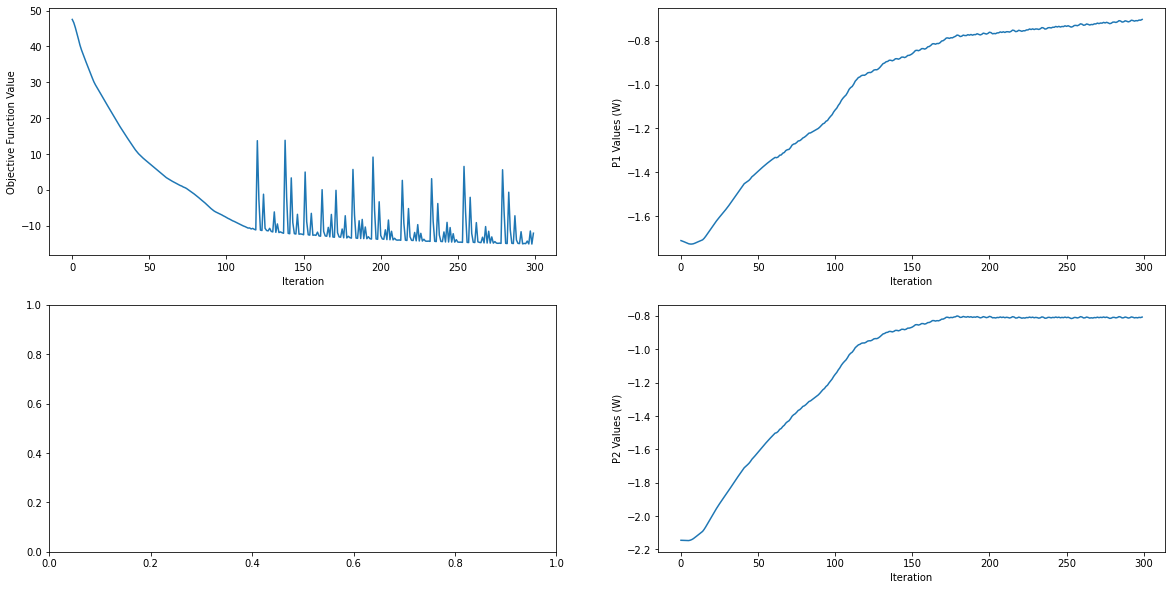

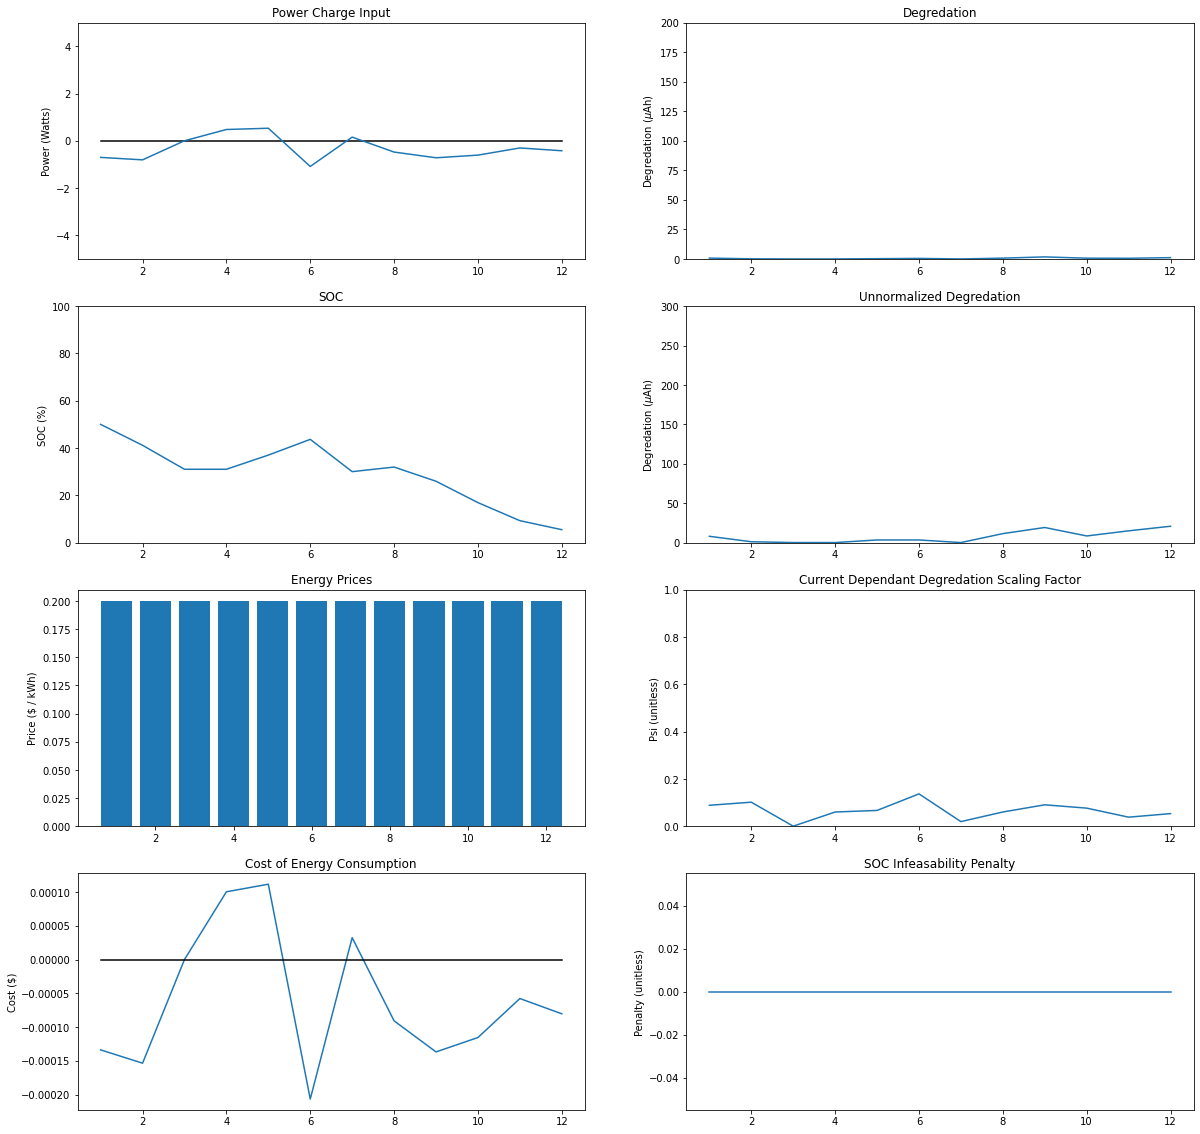

In [6]:
t = 12
w_C = 0.5
SOC_0 = 50.0
lr = 0.005 * t**0.5
rho = 5000.0
rho_SOC = 50.0
beta = 0.5
lr_decay = 0.999
n_iter = 300
trials = 1

cost = Cost(t)
bat = Battery()

start_time = time.time()

final_P, train_cache = optimize(lr, n_iter, w_C, rho, rho_SOC, beta, lr_decay, trials)
final_f, cache = objective(final_P, SOC_0=SOC_0, w_C=w_C, rho=rho, rho_SOC=rho_SOC, verbose=True)

# train_cache = grads, losses, Ps
# cache = P, SOC_ts, d_ts, d_t1cs, psi_ts, SOC_penalties, prices, c_ts, w_C

print("--- %s seconds ---" % (time.time() - start_time))


plotLoss(train_cache)
plotCache(cache)

In [7]:
# Max and min degradation assuming worst and best cases (assuming t=12)
print('Max possible degradation:  ', 3555.0)
print('Min possible degradation:  ', 0.0)

Max possible degradation:   3555.0
Min possible degradation:   0.0


In [8]:
# train_cache = grads, losses, Ps
# cache = P, SOC_ts, d_ts, d_t1cs, psi_ts, SOC_penalties, prices, c_ts, w_C
def calcPareto(n_w=5):
    start_time = time.time()
    w_Cs = np.linspace(0.0, 1.0, num=n_w)
    caches = []
    for w_C in w_Cs:
        final_P, train_cache = optimize(lr, n_iter, w_C, rho, rho_SOC, beta, lr_decay, trials)
        final_f, cache = objective(final_P, SOC_0=SOC_0, w_C=w_C, rho=rho, rho_SOC=rho_SOC, verbose=True)
        caches.append(cache)
    print("--- %s seconds ---" % (time.time() - start_time))
    return caches


In [9]:
def plotPareto(caches):
    Ds, Cs, w_Cs = [], [] , []
    for cache in caches:
        P, SOC_ts, d_ts, d_t1cs, psi_ts, SOC_penalties, prices, c_ts, w_C = cache
        D = np.sum(d_ts)
        C = np.sum(c_ts)
        Ds.append(D)
        Cs.append(C)
        w_Cs.append(w_C)
        
    fig, ax = plt.subplots()
    ax.scatter(Ds, Cs)

    for i, w_C in enumerate(w_Cs):
        ax.annotate(round(w_C, 2), (Ds[i], Cs[i]))
        
    ax.set_title("Pareto Frontier Curve")
    ax.set_ylabel("Cost ($)")
    ax.set_xlabel("Degradation ($\mu$Ah)")


In [10]:
t = 12
w_C = None
SOC_0 = 50.0
lr = 0.005 * t**0.5
rho = 5000.0
rho_SOC = 50.0
beta = 0.5
lr_decay = 0.999
n_iter = 500
trials = 1
n_w = 5

cost = Cost(t)
bat = Battery()


caches = calcPareto(n_w)
plotPareto(caches)

KeyboardInterrupt: 

In [ ]:
plotCache(caches[-1])

In [ ]:
bat = Battery()
bat.plotCum_Deg()

In [ ]:
bat.plotPsi()

In [107]:
# Parameters x, xi [value for k(x, xi)]
# Parametrs l --> Characteristic length
def squared_exponential(x, xi, l = 5/4):
    rtn = np.exp(-(.75*(x - xi))**2/(2*l**2))
    return rtn

# Periodic Kernel
# # Parameters x, xi [value for k(x, xi)]
# Parametrs l --> Characteristic length
# Taken from: https://www.cs.toronto.edu/~duvenaud/cookbook/
def periodic_kernel(x, xi, l = 2):
    a = np.exp(-2*(np.sin(np.pi/24*np.abs(x - xi))**2)/l**2)
    return a

# Create the kernel matrix from two lists of X and Xpr
def kernel_matrix(X, Xpr, w1 = .95, w2 = .05):
    j = np.array([w1*squared_exponential(a, b) + w2*periodic_kernel(a,b) for a in X['Days'] for b in Xpr['Days']])
    return j.reshape((len(X), len(Xpr)))


# Predict the mean based on the data you are predicting from
def mean_predict(df, hr):
    # This might be unreasonable (how else can we predict mean?)
    #df = df[df['Days'] < day]
    correct_hour = df[df['hour'] == hr]
    return np.mean(correct_hour.AEP_MW)

# Sample from the multivariate random normal distributtion
# scalar --> a scalar that is manually tuned to give more varied samples (the higher the value, the larger the covariance matrix)
def mvnrand(μ, Σ, inflation=1e-6, scalar = 3000000):
    #np.random.seed(31)
    sigma = Σ + inflation*np.eye(Σ.shape[0])
    
    x = np.random.multivariate_normal(μ, scalar*sigma, 1)# 100000
    return x[0]

# Will use this to fit our gaussian process to a sinusoidal output
# hours (hours of the day)
# avg, ampl, time_offset --> characteristics of a sinusoidal function
# Return: Function that fits avg, ampl, time_offset as well as possible
def periodic_fit(hours, avg, ampl, time_offset):    
    return (avg
            + ampl * np.cos((hours + time_offset) * 2 * np.pi / hours.max()))

def getGaussianProcess(X, Xpr):
    # Use prior 3 days to predict next day
    # Form kernels
    K_XX = kernel_matrix(X, X)
    K_XXpr = kernel_matrix(X, Xpr)
    K_XprX = kernel_matrix(Xpr, X)
    K_XprXpr = kernel_matrix(Xpr, Xpr)
    # Form means
    meanX = np.array([mean_predict(X, hr) for hr in X['hour']])
    meanXpr = np.array([mean_predict(X, hr) for hr in Xpr['hour']])
    # actual y value
    y = X['AEP_MW']
    mu = meanXpr + K_XprX@np.linalg.inv(K_XX)@(y - meanX)
    cov =  K_XprXpr - K_XprX@np.linalg.inv(K_XX)@K_XXpr
    
    return mu, cov

from scipy import optimize

# Given the previous H hours of MWh Energy, gives a prediction of the next 24 hours of cost based on risk_aversity
# of the customer and utilizing Gaussian Process
def getNextNCosts(n, X, H, day = 100, risk_aversity = 50, samples = 10):
    # Start at a random day of the year
    X = X[X['Days'] < day]
    X = X.iloc[-H:]
    last_hour_measured = list(X['Days'])[-1]
    hours_to_predict = pd.DataFrame()
    hours_to_predict['Days'] = list(range(last_hour_measured - 1, last_hour_measured + n - 1))
    hours_to_predict['hour'] = np.array(list(X['hour'])[-48:-48+25]) # This needs to be edited
    print(hours_to_predict)
    print(X)
    mu, cov = getGaussianProcess(X, hours_to_predict)
    print(mu, cov)
    #create the weighting array
    y_weight = np.empty(n)
    #high pseudo-sd values, meaning less weighting in the fit
    y_weight.fill(10)
    #low values for point 0 and the last points, meaning more weighting during the fit procedure 
    y_weight[0] = .1
    
    worst = None
    worst_value = -float('inf')
    for i in range(samples):
        print("hey")
        j = mvnrand(mu, cov)
        area = np.trapz(range(len(j)), j)
        print('area:', area)
        if area > worst_value:
            worst_value = area
            print('worst')
            worst = j  
    
    plt.figure()
    plt.plot(range(-71,1), X['AEP_MW'], 'g')
    

    res_max, cov_max = optimize2.curve_fit(periodic_fit, list(range(25)),
                                      worst, [0, 0, 0], sigma = y_weight)
    plt.plot(np.array(range(25)), periodic_fit(np.array(range(25)), *res_max), 'pink')

    

In [105]:
df = pd.read_csv('AEP.csv')
df['Date'] = pd.to_datetime(df['Datetime'])
df['year'] = pd.DatetimeIndex(df['Date']).year
df['hour'] = pd.DatetimeIndex(df['Date']).hour
df_18 = df[df['year'] == 2018]
df_18['Days'] = range(len(df_18))

C:\Users\nico\AppData\Local\Temp/ipykernel_19928/2782767335.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_18['Days'] = range(len(df_18))


In [ ]:
getNextNCosts(25, df_18, 72, 100)